# Visualization Sequence AGR 2017

In [3]:
!pip install gpxplotter

from gpxplotter import read_gpx_file, create_folium_map, add_segment_to_map
import folium

the_map = create_folium_map()
for track in read_gpx_file('./gpx_files/gpx_before_dem/2017 Amstel Gold Race.gpx'):
    for i, segment in enumerate(track['segments']):
        add_segment_to_map(the_map, segment)

folium_gpx = folium.PolyLine(segment['latlon'][50:55], color='red', weight=5, opacity=0.85).add_to(the_map)

the_map

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/7.7 MB ? eta -:--:--
   ------------- -------------------------- 2.6/7.7 MB 12.5 MB/s eta 0:00:01
   ---------------------------------------- 7.7/7.7 MB 21.5 MB/s eta 0:00:00
  Created wheel for vincent: filename=vincent-0.4.4-py3-none-any.whl size=35223 sha256=99a9cd8904a8f74466811d342961f54cef321d97a60163a27b46f65952d55a2e
  Stored in directory: c:\users\mrmik\appdata\local\pip\cache\wheels\e0\31\2d\d6c74889798221a8e0d73192d7af2f132da7bc9ae2e072f892
Successfully built vincent


C:\Users\mrmik\anaconda3\Lib\site-packages\gpxplotter\common.py:191: UserWarning: Some velocities are NaN, skipping clustering
  warnings.warn("Some velocities are NaN, skipping clustering")


# Heatmap

In [13]:
pip install gpxpy
pip install haversine

SyntaxError: invalid syntax (2127265650.py, line 1)

In [11]:
import pickle
import gpxpy
import gpxpy.gpx

import pandas as pd
import numpy as np
import haversine as hs
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

SAVE_DIR = './gpx_files/gpx_before_dem/'
all_files = [f for f in listdir(SAVE_DIR) if isfile(join(SAVE_DIR, f))]

storer = []

for file in all_files:
    

    try:
        FILE_DIR = SAVE_DIR +'\\'+ file

        with open(FILE_DIR, 'r') as gpx_file:
            gpx = gpxpy.parse(gpx_file)
    except:
        continue
 
    route_info = []
    new_gpx = [point for i, point in enumerate(gpx.tracks[0].segments[0].points)]

    for point in new_gpx:
        route_info.append({
            'latitude': point.latitude,
            'longitude': point.longitude,
            'elevation': point.elevation
        })

    route_df = pd.DataFrame(route_info)
    route_df['RaceName'] = str(file)
    storer.append(route_df)

geo_df = pd.concat(storer)

from folium.plugins import HeatMap

m = folium.Map(location=[geo_df.latitude.mean(), 
                         geo_df.longitude.mean()], 
               zoom_start=6, control_scale=True)

geo_df['lat_round'] = round(geo_df['latitude'], 3)
geo_df['lon_round'] = round(geo_df['longitude'], 3)

freq_df = geo_df.groupby(by=["lat_round", "lon_round"]).size().reset_index(name="Frequency")

map_values = freq_df[['lat_round','lon_round','Frequency']]

data = map_values.values.tolist()

hm = HeatMap(data,
              min_opacity=0.05, 
              max_opacity=0.9, 
              radius=25).add_to(m)

m

ModuleNotFoundError: No module named 'haversine'

# Evaluation Elevation Quality

In [7]:
dem = './gpx_files/gpx_after_dem/'
initial =  './gpx_files/gpx_before_dem/'

import math
from tqdm import tqdm
from gpxpy import gpx
import pandas as pd
import numpy as np

before = listdir(initial)
after = listdir(dem)

rmses=[]
max_diffs = []
for file in tqdm(before):
    with open(initial+file, 'r', encoding="utf-8") as gpx_file:
        gpx = gpxpy.parse(gpx_file)
        track_elevation_series_before = []
        for data_point in gpx.tracks[0].segments[0].points:
            track_elevation_series_before.append(data_point.elevation)
    with open(dem+file, 'r', encoding="utf-8") as gpx_file:
        gpx = gpxpy.parse(gpx_file)
        track_elevation_series_after = []
        for data_point in gpx.tracks[0].segments[0].points:
            track_elevation_series_after.append(data_point.elevation)
    MSE = np.square(np.subtract(track_elevation_series_after, track_elevation_series_before)).mean()  
    RMSE = math.sqrt(MSE)  
    rmses.append(RMSE)
    max_diffs.append(np.max(np.abs(np.array(track_elevation_series_after)-np.array(track_elevation_series_before))))
    
print('RMSE: '+str(np.mean(rmses)))    
print('Mean Maximal Difference: '+str(np.mean(max_diffs)))    

ModuleNotFoundError: No module named 'gpxpy'

In [65]:
import haversine as hs
import matplotlib.pyplot as plt

TWO_COL_SIZE_X = 15

def haversine_distance(lat1, lon1, lat2, lon2) -> float:
    distance = hs.haversine(
        point1=(lat1, lon1),
        point2=(lat2, lon2),
        unit=hs.Unit.METERS
    )
    return np.round(distance, 2)


def elevation_quality(save_as='elevation.jpg'):

    # Create a figure and axis
    fig, ax = plt.subplots(2, 2, figsize=(TWO_COL_SIZE_X, TWO_COL_SIZE_X * 0.5))
    
    files = ['2017 Brussels Cycling Classic.gpx','2017 Tour des Fjords Stage 3.gpx']
    for j, file in enumerate(files):

        # Read data 
        with open(dem+file, 'r', encoding="utf-8") as gpx_file:
            route_info = []
            gpx = gpxpy.parse(gpx_file)
            data_new = [data_point for data_point in gpx.tracks[0].segments[0].points]
        with open(initial+file, 'r', encoding="utf-8") as gpx_file2:
            route_info = []
            gpx = gpxpy.parse(gpx_file2)
            data_old = [data_point for data_point in gpx.tracks[0].segments[0].points]

        # Preprocess old
        track_elevation_series = []

        route_info = []

        for data_point in data_old:
            track_elevation_series.append(data_point.elevation)
            route_info.append({
                'latitude': data_point.latitude,
                'longitude': data_point.longitude
            })

        route_df = pd.DataFrame(route_info)
        distances = [np.nan]
        for i in range(len(route_df)):
            if i == 0:
                continue
            else:
                distances.append(haversine_distance(
                    lat1=route_df.iloc[i - 1]['latitude'],
                    lon1=route_df.iloc[i - 1]['longitude'],
                    lat2=route_df.iloc[i]['latitude'],
                    lon2=route_df.iloc[i]['longitude']
                ))

        route_df['distance'] = distances

        route_df['Covered Distance'] = route_df['distance'].cumsum()
        route_df['Elevation'] = track_elevation_series

        old_df = route_df

        old_df = old_df.fillna(0)


        #ax[i][0].ylim((-50, 750))
        if j==1:
            ax[j][0].set_xlabel('Distance Covered (km)',  fontsize='14', horizontalalignment='center')
            ax[j][0].set_ylim((-50, 750))
        ax[j][0].set_ylabel('Elevation (m)',  fontsize='14')
        ax[j][0].plot(np.array(old_df['Covered Distance']/1000), np.array(old_df['Elevation']))

        char = chr(97 + 2*j)
        
        ax[j, 0].text(-0.025, 1.1, '%s)' % char, fontsize=12,
                            horizontalalignment='center', verticalalignment='center',
                            transform=ax[j, 0].transAxes)
        track_elevation_series = []

        route_info = []

        for data_point in data_new:
            track_elevation_series.append(data_point.elevation)
            route_info.append({
                'latitude': data_point.latitude,
                'longitude': data_point.longitude
            })

        route_df = pd.DataFrame(route_info)
        distances = [np.nan]
        for i in range(len(route_df)):
            if i == 0:
                continue
            else:
                distances.append(haversine_distance(
                    lat1=route_df.iloc[i - 1]['latitude'],
                    lon1=route_df.iloc[i - 1]['longitude'],
                    lat2=route_df.iloc[i]['latitude'],
                    lon2=route_df.iloc[i]['longitude']
                ))

        route_df['distance'] = distances

        route_df['Covered Distance'] = route_df['distance'].cumsum()
        route_df['Elevation'] = track_elevation_series

        new_df = route_df
        new_df = new_df.fillna(0)    
        
        ax[j][1].plot(np.array(new_df['Covered Distance']/1000), np.array(new_df['Elevation']))

        
        if j==1:
            ax[j][1].set_xlabel('Distance Covered (km)', fontsize='14', horizontalalignment='center')
            ax[j][1].set_ylim((-50, 750))

        char = chr(97 + 2*j + 1)
        
        ax[j, 1].text(-0.025, 1.1, '%s)' % char, fontsize=12,
                            horizontalalignment='center', verticalalignment='center',
                            transform=ax[j, 1].transAxes)
    
    #fig.tight_layout(pad=0)

    plt.savefig(f'Images/{save_as}', bbox_inches='tight')
    plt.show()


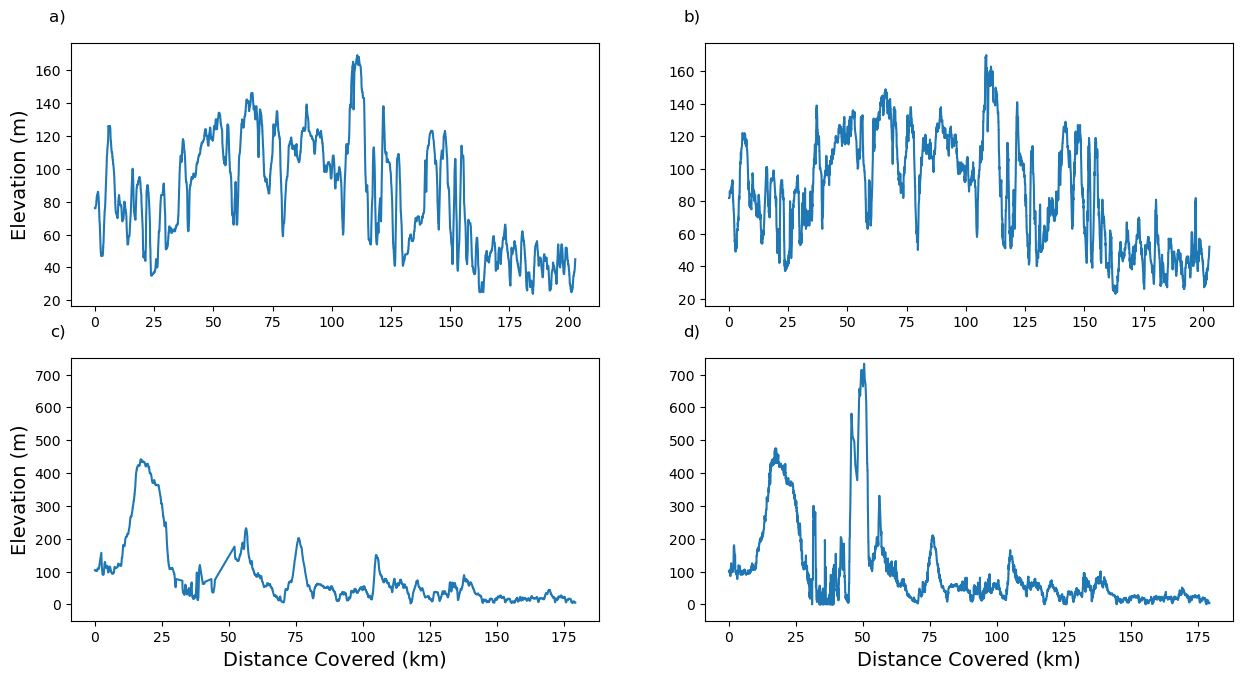

In [67]:
elevation_quality()

# Histograms

In [86]:
structured_info_df = pd.read_csv('structured_course_data.csv')

structured_info_df['gravel_binary'] = np.where(structured_info_df['Compacted Gravel']>0,'1','0')
structured_info_df['cobble_binary'] = np.where(structured_info_df['Cobblestones']>0,'1','0')
structured_info_df['Special Road Sections'] = structured_info_df['gravel_binary'].astype(str)+structured_info_df['cobble_binary'].astype(str)

di = {'00': "No G/C\n Sections", '01': "Only C\n Sections", '10': "Only G\n Sections", '11': 'Both G&C \n Sections'}
structured_info_df = structured_info_df.replace({'Special Road Sections': di})

TWO_COL_SIZE_X = 15

def histograms(save_as='histograms.jpg'):

    # Create a figure and axis
    fig, ax = plt.subplots(1, 3, figsize=(TWO_COL_SIZE_X, TWO_COL_SIZE_X * 0.25))
    
    ax[0].hist(structured_info_df['Distance'])
    ax[0].set_xlabel('\n Distance (km)', fontsize='14', horizontalalignment='center')
    ax[0].set_ylabel('Number of Races', fontsize='14')
    ax[0].set_ylim((0, 7000))
    ax[0].text(-0.025, 1.1, '%s)' % 'a', fontsize=12,
                        horizontalalignment='center', verticalalignment='center',
                        transform=ax[0].transAxes)    
    ax[1].hist(structured_info_df['Net Gain'])
    ax[1].set_xlabel('\n Elevation Difference between Finish and Start (m)', fontsize='14', horizontalalignment='center')
    ax[1].set_ylim((0, 7000))
    ax[1].text(-0.025, 1.1, '%s)' % 'b', fontsize=12,
                        horizontalalignment='center', verticalalignment='center',
                        transform=ax[1].transAxes)  
    
    ax[2].hist(structured_info_df['Special Road Sections'], bins=np.arange(5)-0.5, width = 0.9)
    ax[2].set_xlabel('Distribution Races With \n Gravel and Cobble Sections', fontsize='14', horizontalalignment='center')
    ax[2].set_ylim((0, 7000))
    ax[2].text(-0.025, 1.1, '%s)' % 'c', fontsize=12,
                        horizontalalignment='center', verticalalignment='center',
                        transform=ax[2].transAxes)  
    
    #fig.tight_layout(pad=0)

    plt.savefig(f'Images/{save_as}', bbox_inches='tight')
    plt.show()

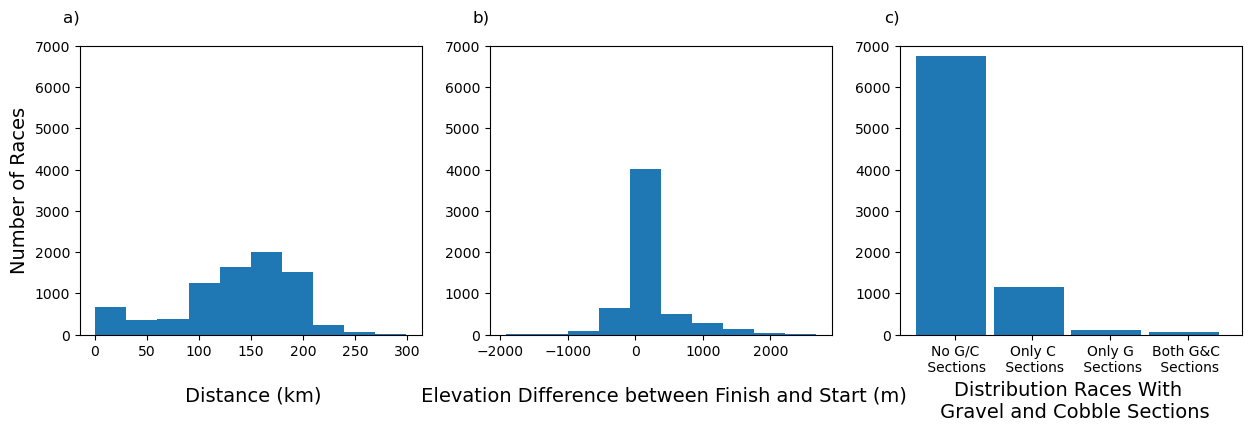

In [87]:
histograms()

# Clustering

In [155]:
import pandas as pd
import random
from sklearn import cluster
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

def cop_kmeans(dataset, k, ml=[], cl=[],
               initialization='kmpp',
               max_iter=300, tol=1e-4):

    ml, cl = transitive_closure(ml, cl, len(dataset))
    ml_info = get_ml_info(ml, dataset)
    tol = tolerance(tol, dataset)

    centers = initialize_centers(dataset, k, initialization)

    for _ in range(max_iter):
        clusters_ = [-1] * len(dataset)
        for i, d in enumerate(dataset):
            indices, _ = closest_clusters(centers, d)
            counter = 0
            if clusters_[i] == -1:
                found_cluster = False
                while (not found_cluster) and counter < len(indices):
                    index = indices[counter]
                    if not violate_constraints(i, index, clusters_, ml, cl):
                        found_cluster = True
                        clusters_[i] = index
                        for j in ml[i]:
                            clusters_[j] = index
                    counter += 1

                if not found_cluster:
                    return None, None

        clusters_, centers_ = compute_centers(clusters_, dataset, k, ml_info)
        shift = sum(l2_distance(centers[i], centers_[i]) for i in range(k))
        if shift <= tol:
            break

        centers = centers_

    return clusters_, centers_

def l2_distance(point1, point2):
    return np.sum([(float(i)-float(j))**2 for (i, j) in zip(point1, point2)])

# taken from scikit-learn (https://goo.gl/1RYPP5)
def tolerance(tol, dataset):
    n = len(dataset)
    dim = len(dataset[0])
    averages = [sum(dataset[i][d] for i in range(n))/float(n) for d in range(dim)]
    variances = [sum((dataset[i][d]-averages[d])**2 for i in range(n))/float(n) for d in range(dim)]
    return tol * sum(variances) / dim

def closest_clusters(centers, datapoint):
    distances = [l2_distance(center, datapoint) for
                 center in centers]
    return sorted(range(len(distances)), key=lambda x: distances[x]), distances

def initialize_centers(dataset, k, method):
    if method == 'random':
        ids = list(range(len(dataset)))
        random.shuffle(ids)
        return [dataset[i] for i in ids[:k]]

    elif method == 'kmpp':
        chances = [1] * len(dataset)
        centers = []

        for _ in range(k):
            chances = [x/sum(chances) for x in chances]
            r = random.random()
            acc = 0.0
            for index, chance in enumerate(chances):
                if acc + chance >= r:
                    break
                acc += chance
            centers.append(dataset[index])

            for index, point in enumerate(dataset):
                cids, distances = closest_clusters(centers, point)
                chances[index] = distances[cids[0]]

        return centers

def violate_constraints(data_index, cluster_index, clusters, ml, cl):
    for i in ml[data_index]:
        if clusters[i] != -1 and clusters[i] != cluster_index:
            return True

    for i in cl[data_index]:
        if clusters[i] == cluster_index:
            return True

    return False

def compute_centers(clusters, dataset, k, ml_info):
    cluster_ids = set(clusters)
    k_new = len(cluster_ids)
    id_map = dict(zip(cluster_ids, range(k_new)))
    clusters = [id_map[x] for x in clusters]

    dim = len(dataset[0])
    centers = [[0.0] * dim for i in range(k)]

    counts = [0] * k_new
    for j, c in enumerate(clusters):
        for i in range(dim):
            centers[c][i] += dataset[j][i]
        counts[c] += 1

    for j in range(k_new):
        for i in range(dim):
            centers[j][i] = centers[j][i]/float(counts[j])

    if k_new < k:
        ml_groups, ml_scores, ml_centroids = ml_info
        current_scores = [sum(l2_distance(centers[clusters[i]], dataset[i])
                              for i in group)
                          for group in ml_groups]
        group_ids = sorted(range(len(ml_groups)),
                           key=lambda x: current_scores[x] - ml_scores[x],
                           reverse=True)

        for j in range(k-k_new):
            gid = group_ids[j]
            cid = k_new + j
            centers[cid] = ml_centroids[gid]
            for i in ml_groups[gid]:
                clusters[i] = cid

    return clusters, centers

def get_ml_info(ml, dataset):
    flags = [True] * len(dataset)
    groups = []
    for i in range(len(dataset)):
        if not flags[i]: continue
        group = list(ml[i] | {i})
        groups.append(group)
        for j in group:
            flags[j] = False

    dim = len(dataset[0])
    scores = [0.0] * len(groups)
    centroids = [[0.0] * dim for i in range(len(groups))]

    for j, group in enumerate(groups):
        for d in range(dim):
            for i in group:
                centroids[j][d] += dataset[i][d]
            centroids[j][d] /= float(len(group))

    scores = [sum(l2_distance(centroids[j], dataset[i])
                  for i in groups[j])
              for j in range(len(groups))]

    return groups, scores, centroids

def transitive_closure(ml, cl, n):
    ml_graph = dict()
    cl_graph = dict()
    for i in range(n):
        ml_graph[i] = set()
        cl_graph[i] = set()

    def add_both(d, i, j):
        d[i].add(j)
        d[j].add(i)

    for (i, j) in ml:
        add_both(ml_graph, i, j)

    def dfs(i, graph, visited, component):
        visited[i] = True
        for j in graph[i]:
            if not visited[j]:
                dfs(j, graph, visited, component)
        component.append(i)

    visited = [False] * n
    for i in range(n):
        if not visited[i]:
            component = []
            dfs(i, ml_graph, visited, component)
            for x1 in component:
                for x2 in component:
                    if x1 != x2:
                        ml_graph[x1].add(x2)
    for (i, j) in cl:
        add_both(cl_graph, i, j)
        for y in ml_graph[j]:
            add_both(cl_graph, i, y)
        for x in ml_graph[i]:
            add_both(cl_graph, x, j)
            for y in ml_graph[j]:
                add_both(cl_graph, x, y)

    for i in ml_graph:
        for j in ml_graph[i]:
            if j != i and j in cl_graph[i]:
                raise Exception('inconsistent constraints between %d and %d' %(i, j))

    return ml_graph, cl_graph

In [156]:
import warnings
warnings.filterwarnings('ignore')

random.seed(1853)
np.random.seed(1853)

df = pd.read_csv('structured_course_data.csv')
no_imputation_df = df[-(df==0)]

matching_annotation = pd.read_csv('named_annotation_NOV23.csv')

test_index = random.sample(list(matching_annotation.index), 100)
train_index = list(set(list(matching_annotation.index)).difference(set(test_index)))

train_set = matching_annotation.iloc[train_index]
test_set = matching_annotation.iloc[test_index]

must_link = train_set[train_set['Label']=='MustLink']
cannot_link = train_set[train_set['Label']=='CannotLink']

df = df.fillna(0)

nieuwe_tussen = df['Race Name']
nieuwe_tussen = pd.DataFrame(nieuwe_tussen)
nieuwe_tussen['index2'] = range(nieuwe_tussen.shape[0])

name_keep = df['Race Name']
X = df.drop(columns = 'Race Name')
X = StandardScaler().fit_transform(X)

results_list_constrained = []
for k_set in range(5,16):
    k_means = cluster.MiniBatchKMeans(n_clusters=k_set, batch_size = 2048)
    k_means.fit(X)
    results_list_constrained.append(k_means.labels_.astype(int))
    
merged_set_constrained = pd.concat([df,pd.DataFrame(np.matrix(results_list_constrained).transpose())], axis = 1)
evaluation_constrained = test_set[['name2_x', 'name2_y', 'Label']].merge(merged_set_constrained, left_on = 'name2_x', right_on = 'Race Name').merge(merged_set_constrained, left_on = 'name2_y', right_on = 'Race Name') 

scores_constrained = []
silhouette_scores = []

for i in range(11):
    score = 0
    clust1 = str(i)+'_x'
    clust2 = str(i)+'_y'
    for j in range(evaluation_constrained.shape[0]):
        subject = evaluation_constrained.iloc[j,:]
        if subject[clust1]==subject[clust2]:
            if subject['Label']=='MustLink':
                score+=1
        else:
            if subject['Label']=='CannotLink':
                score+=1

    silhouette_avg = silhouette_score(X, merged_set_constrained[i])
            
    scores_constrained.append(score)
    silhouette_scores.append(silhouette_avg)
     
    
scores_constrained    

[70, 83, 76, 74, 72, 69, 80, 75, 74, 73, 75]

In [157]:
silhouette_scores

[0.16484176715134893,
 0.12990586607621482,
 0.1552255684141979,
 0.1685370736066385,
 0.19148006794156028,
 0.15378257738075138,
 0.16154585475180186,
 0.17133980922656528,
 0.15326314682166972,
 0.18144664423876739,
 0.18191167487627558]

In [158]:
random.seed(1853)
np.random.seed(1853)

from sklearn.impute import KNNImputer

nieuwe_tussen = no_imputation_df['Race Name']
nieuwe_tussen = pd.DataFrame(nieuwe_tussen)
nieuwe_tussen['index2'] = range(nieuwe_tussen.shape[0])

X2 = no_imputation_df.drop(columns = 'Race Name')
imputer = KNNImputer()
X2 = imputer.fit_transform(X2)
X2 = StandardScaler().fit_transform(X2)

results_list_constrained2 = []
for k_set in range(5,16):
    k_means = cluster.MiniBatchKMeans(n_clusters=k_set, batch_size = 2048)
    k_means.fit(X2)
    results_list_constrained2.append(k_means.labels_.astype(int))
    
merged_set_constrained2 = pd.concat([no_imputation_df,pd.DataFrame(np.matrix(results_list_constrained2).transpose())], axis = 1)
evaluation_constrained2 = test_set[['name2_x', 'name2_y', 'Label']].merge(merged_set_constrained2, left_on = 'name2_x', right_on = 'Race Name').merge(merged_set_constrained2, left_on = 'name2_y', right_on = 'Race Name')

scores_constrained2 = []
silhouette_scores2 = []

for i in range(11):
    score = 0
    clust1 = str(i)+'_x'
    clust2 = str(i)+'_y'
    for j in range(evaluation_constrained2.shape[0]):
        subject = evaluation_constrained2.iloc[j,:]
        if subject[clust1]==subject[clust2]:
            if subject['Label']=='MustLink':
                score+=1
        else:
            if subject['Label']=='CannotLink':
                score+=1
                
    silhouette_avg = silhouette_score(X2, merged_set_constrained2[i])
            
    scores_constrained2.append(score)
    silhouette_scores2.append(silhouette_avg)
    
scores_constrained2

[83, 72, 74, 78, 67, 70, 65, 71, 53, 73, 63]

In [160]:
silhouette_scores2

[0.13399091739815783,
 0.12214113238771349,
 0.1263282192772821,
 0.08372582333411817,
 0.11226847891165512,
 0.1197220665026365,
 0.1274962777944248,
 0.12728261820167916,
 0.11430716192123994,
 0.10193169277770239,
 0.10648192554076118]

In [234]:
def clustering(save_as='clusters.jpg'):

    # Create a figure and axis
    fig, ax = plt.subplots(1, 2, figsize=(TWO_COL_SIZE_X, TWO_COL_SIZE_X * 0.5))
    
    ax[0].plot(range(5,16), scores_constrained, label ='Zero Imputation')
    ax[0].plot(range(5,16), scores_constrained2, '-.', label ='KNN Imputation')
    ax[0].set_xlabel('K = Number of Clusters', fontsize='14', horizontalalignment='center')
    ax[0].set_ylabel('Correctly linked/unlinked pairs (/100)', fontsize='14')
    ax[0].text(-0.025, 1.1, '%s)' % 'a', fontsize=12,
                        horizontalalignment='center', verticalalignment='center',
                        transform=ax[0].transAxes)  
    
    ax[1].plot(range(5,16), silhouette_scores, label ='Zero Imputation')
    ax[1].plot(range(5,16), silhouette_scores2, '-.', label ='KNN Imputation')
    ax[1].set_xlabel('K = Number of Clusters', fontsize='14', horizontalalignment='center')
    ax[1].set_ylabel('Silhouette Score', fontsize='14')
    ax[1].text(-0.025, 1.1, '%s)' % 'b', fontsize=12,
                        horizontalalignment='center', verticalalignment='center',
                        transform=ax[1].transAxes) 

    
    #fig.tight_layout(pad=0)

    plt.savefig(f'Images/{save_as}', bbox_inches='tight')
    plt.show()

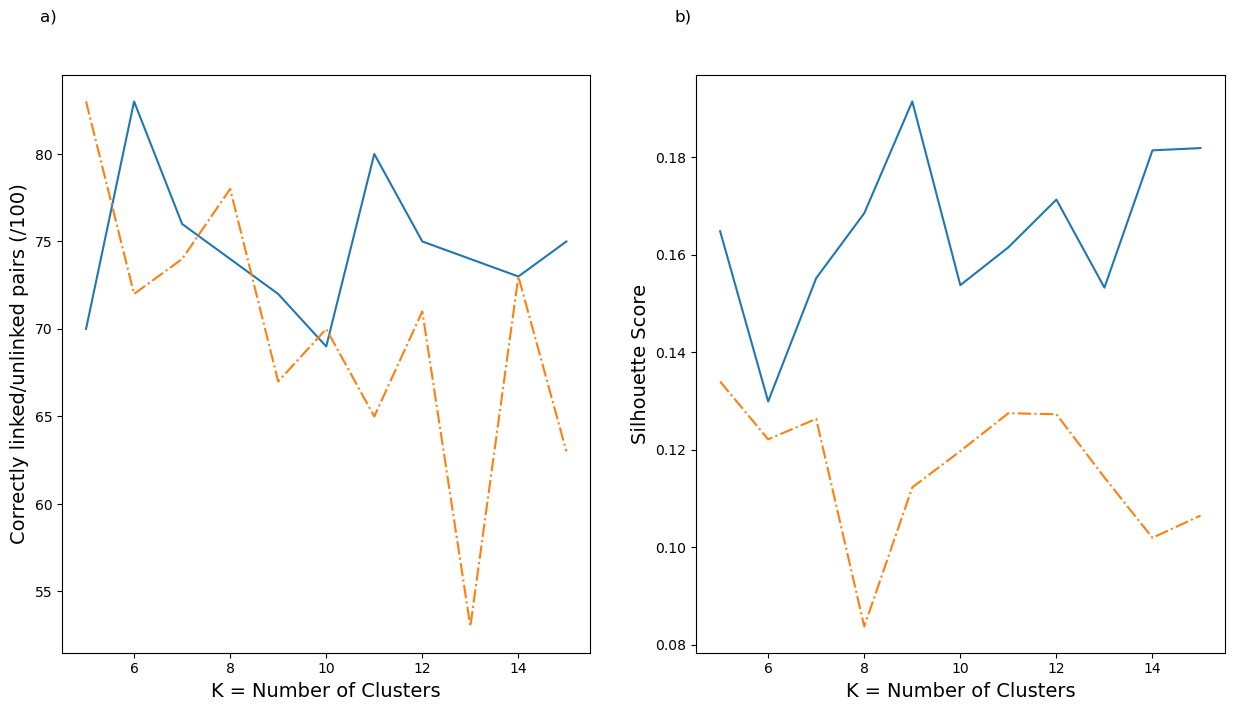

In [235]:
clustering()

In [196]:
# After initial plotting / visual inspection

di = {0: "High Elevation", 1: "Races with Off-Road Sections", 2: "Short/Flat Races", 3:"Sprint Stages" , 
      4:'Races Outside Europe', 5:'Cobble Races', 6:'Mountain Stages', 7:'Wide Roads', 
      8:'Missing Road Types'}

merged_set_constrained = merged_set_constrained.replace({4: di})

In [197]:
merged_set_constrained['Cluster'] = merged_set_constrained[4]

In [314]:
colors = {"High Elevation": 'indianred', "Races with Off-Road Sections": 'skyblue', "Short/Flat Races": 'limegreen', "Sprint Stages" : 'gold' , 
      'Races Outside Europe' : 'dimgray', 'Cobble Races': 'darkviolet', 'Mountain Stages': 'orange', 'Wide Roads': 'pink', 
      'Missing Road Types': 'peru'}

scatter_colors = merged_set_constrained['Cluster'].map(colors)

def scatters(save_as='scatters.jpg'):

    # Create a figure and axis
    fig, ax = plt.subplots(2, 3, figsize=(TWO_COL_SIZE_X, TWO_COL_SIZE_X * 0.5))
    
    ax[0][0].scatter(merged_set_constrained['Net Gain'], merged_set_constrained['Lowest Elevation'], c = scatter_colors)
    ax[0][0].set_xlabel('Net Gain (meters)', fontsize='14', horizontalalignment='center')
    ax[0][0].set_ylabel('Lowest Elevation \n (meters)', fontsize='14')
    ax[0,0].text(-0.025, 1.1, '%s)' % 'a', fontsize=12,
                        horizontalalignment='center', verticalalignment='center',
                        transform=ax[0,0].transAxes)  
    
    ax[0][1].scatter(merged_set_constrained['Distance'], merged_set_constrained['Paved'], c = scatter_colors)
    ax[0][1].set_xlabel('Distance (kilometers)', fontsize='14', horizontalalignment='center')
    ax[0][1].set_ylabel('Paved \n (kilometers)', fontsize='14')
    ax[0,1].text(-0.025, 1.1, '%s)' % 'b', fontsize=12,
                        horizontalalignment='center', verticalalignment='center',
                        transform=ax[0,1].transAxes) 
    
    ax[0][2].scatter(merged_set_constrained['Distance'], merged_set_constrained['Cobblestones'], c = scatter_colors)
    ax[0][2].set_xlabel('Distance (kilometers)', fontsize='14', horizontalalignment='center')
    ax[0][2].set_ylabel('Cobblestones \n (kilometers)', fontsize='14')
    ax[0,2].text(-0.025, 1.1, '%s)' % 'c', fontsize=12,
                        horizontalalignment='center', verticalalignment='center',
                        transform=ax[0,2].transAxes) 
    
    ax[1][0].scatter(merged_set_constrained['Net Gain'], merged_set_constrained['Vertical Gain'], c = scatter_colors)
    ax[1][0].set_xlabel('Net Gain (meters)', fontsize='14', horizontalalignment='center')
    ax[1][0].set_ylabel('Vertical Gain \n (meters)', fontsize='14')
    ax[1,0].text(-0.025, 1.1, '%s)' % 'd', fontsize=12,
                        horizontalalignment='center', verticalalignment='center',
                        transform=ax[1,0].transAxes)  
    
    ax[1][1].scatter(merged_set_constrained['Distance'], merged_set_constrained['Vertical Gain'], c = scatter_colors)
    ax[1][1].set_xlabel('Distance (kilometers)', fontsize='14', horizontalalignment='center')
    ax[1][1].set_ylabel('Vertical Gain \n (meters)', fontsize='14')
    ax[1,1].text(-0.025, 1.1, '%s)' % 'e', fontsize=12,
                        horizontalalignment='center', verticalalignment='center',
                        transform=ax[1,1].transAxes)    
    
    ax[1][2].scatter(merged_set_constrained['Distance'], merged_set_constrained['State Road'], c = scatter_colors)
    ax[1][2].set_xlabel('Distance (kilometers)', fontsize='14', horizontalalignment='center')
    ax[1][2].set_ylabel('State Road \n (kilometers)', fontsize='14')
    ax[1,2].text(-0.025, 1.1, '%s)' % 'f', fontsize=12,
                        horizontalalignment='center', verticalalignment='center',
                        transform=ax[1,2].transAxes)   
    
    labels = list(colors.keys())
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label]) for label in labels]
    plt.legend(handles, labels, fontsize=10, bbox_to_anchor=(1.3,1))


    
    fig.tight_layout(pad=0)

    plt.savefig(f'Images/{save_as}', bbox_inches='tight')
    plt.show()


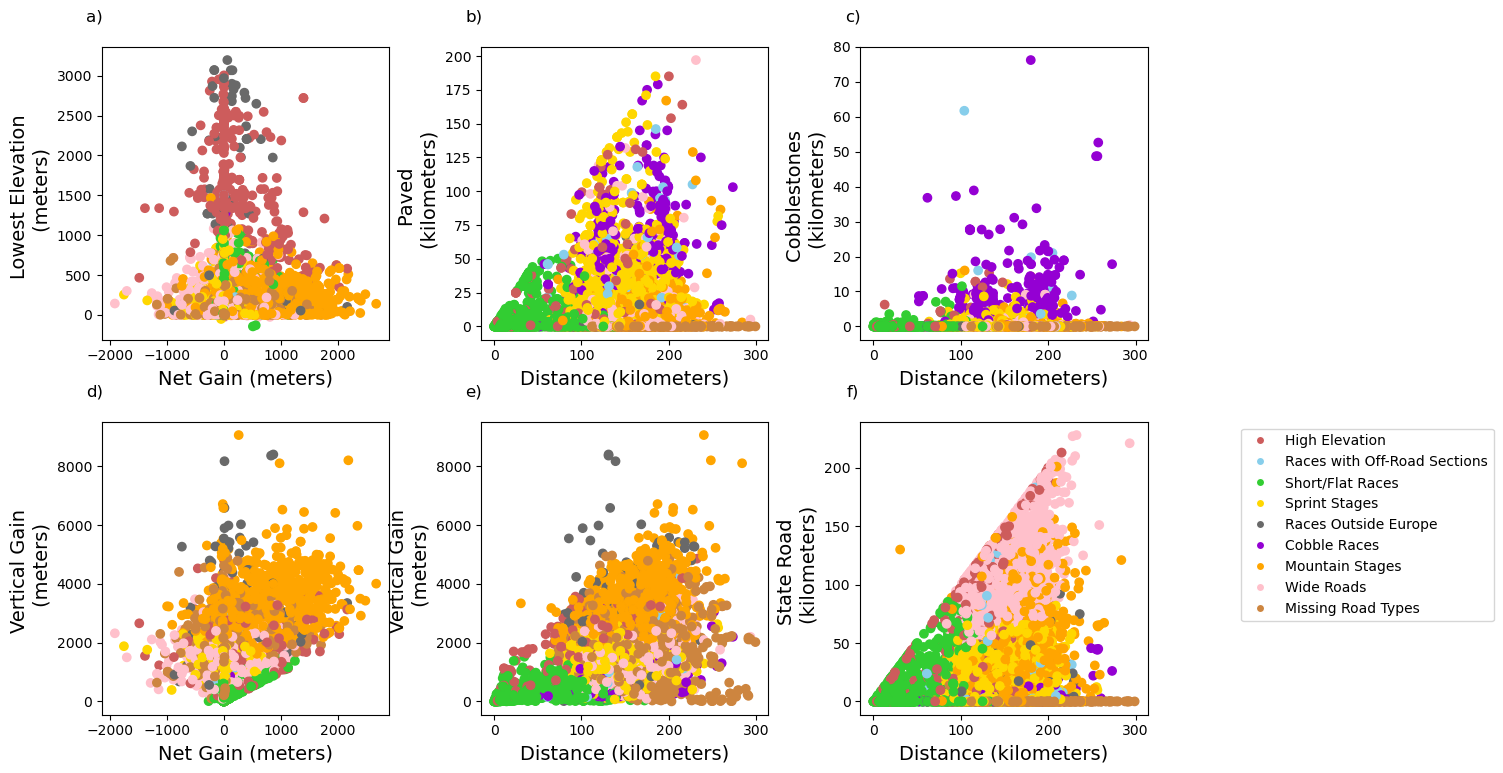

In [315]:
scatters()

In [319]:
df.columns

Index(['Unnamed: 0', 'Race Name', 'Distance', 'Street', 'Road', 'Paved',
       'Asphalt', 'Path', 'Cycleway', 'Unpaved', 'State Road', 'Cobblestones',
       'Unknown', 'Compacted Gravel', 'Off-grid (unknown)', 'Singletrack',
       'Access Road', 'Alpine', 'Net Gain', 'Lowest Elevation',
       'Highest Elevation', 'Vertical Gain', 'Downhill'],
      dtype='object')

In [318]:
merged_set_constrained['Cluster'].value_counts()

Sprint Stages                   2070
Short/Flat Races                1397
Missing Road Types              1301
Mountain Stages                 1155
Wide Roads                      1067
Cobble Races                     415
High Elevation                   372
Races Outside Europe             220
Races with Off-Road Sections      97
Name: Cluster, dtype: int64

In [329]:
relevant_features = merged_set_constrained[df.columns]
relevant_features = relevant_features.drop(columns = 'Unnamed: 0')
relevant_features = relevant_features.drop(columns = 'Race Name')

In [330]:
from scipy.spatial.distance import cdist

unique_labels = merged_set_constrained['Cluster'].unique()

medoids = []

for label in unique_labels:

    cluster_points = relevant_features.loc[merged_set_constrained['Cluster'] == label, :]
    distances = cdist(cluster_points, cluster_points)
    sum_distances = np.sum(distances, axis=1)
    medoid_index = np.argmin(sum_distances)
    medoid = cluster_points.iloc[medoid_index, :]
    medoids.append(medoid)

In [339]:
racenames = []

for med in medoids:
    first_set = merged_set_constrained[merged_set_constrained['Distance']==med['Distance']]
    if first_set.shape[0]>1:
        first_set = first_set[first_set['Road']==med['Road']]
    if first_set.shape[0]>1:
        first_set = first_set[first_set['Vertical Gain']==med['Vertical Gain']]
    if first_set.shape[0]>1:
        first_set = first_set[first_set['Lowest Elevation']==med['Lowest Elevation']] 
    racenames.append(first_set['Race Name'].values[0])    

In [336]:
unique_labels

array(['Sprint Stages', 'Mountain Stages', 'Short/Flat Races',
       'Cobble Races', 'Wide Roads', 'Races with Off-Road Sections',
       'High Elevation', 'Races Outside Europe', 'Missing Road Types'],
      dtype=object)

In [340]:
racenames

['2022 La Perigord Ladies',
 '2017 Volta a Portugal em Bicicleta Santander Totta Stage 4',
 '2018 Chrono Champenois-Masculin International',
 '2022 Baloise Ladies Tour Stage 2',
 '2022 Tour de Serbie Stage 2',
 '2021 Gylne Gutuer',
 '2018 Tour of the Gila Stage 1',
 '2023 Tour of Kosovo Stage 2',
 '2018 Tour de Hongrie Stage 1']

In [358]:
def medoids(save_as = 'medoids.jpg'):
    fig, axs = plt.subplots(3, 3, figsize = (TWO_COL_SIZE_X, TWO_COL_SIZE_X))

    # Iterate over each race and plot in respective subplot
    for j, race in enumerate(racenames):
        # Open gpx file and parse the data
        with open(initial + race + '.gpx', 'r', encoding="utf-8") as gpx_file2:
            route_info = []
            gpx = gpxpy.parse(gpx_file2)
            data_old = [data_point for data_point in gpx.tracks[0].segments[0].points]

        # Preprocess old
        track_elevation_series = []
        route_info = []

        for data_point in data_old:
            track_elevation_series.append(data_point.elevation)
            route_info.append({
                'latitude': data_point.latitude,
                'longitude': data_point.longitude
            })

        route_df = pd.DataFrame(route_info)
        distances = [np.nan]
        for i in range(len(route_df)):
            if i == 0:
                continue
            else:
                distances.append(haversine_distance(
                    lat1=route_df.iloc[i - 1]['latitude'],
                    lon1=route_df.iloc[i - 1]['longitude'],
                    lat2=route_df.iloc[i]['latitude'],
                    lon2=route_df.iloc[i]['longitude']
                ))

        route_df['distance'] = distances

        route_df['Covered Distance'] = route_df['distance'].cumsum()
        route_df['Elevation'] = track_elevation_series

        old_df = route_df
        old_df = old_df.fillna(0)

        # Get the current subplot axes and plot the data
        ax = axs[j // 3, j % 3]
        ax.plot(np.array(old_df['Covered Distance'] / 1000), np.array(old_df['Elevation']))
        if j == 1:
            ax.set_xlabel('Distance Covered (km) \n 2017 Volta a Portugal em Bicicleta \n Santander Totta Stage 4', fontsize='14', horizontalalignment='center')
        else:    
            ax.set_xlabel('Distance Covered (km) \n' + race, fontsize='14', horizontalalignment='center')
        ax.set_ylim((-50, 2200))
        ax.set_ylabel('Elevation (m)', fontsize='14')
        ax.set_title(unique_labels[j], fontsize='14')

        a_char = 97
        char = chr(a_char + j)

        ax.text(-0.025, 1.145, '%s)' % char, fontsize=12,
                            horizontalalignment='center', verticalalignment='center',
                            transform=ax.transAxes)
        #ax.set_title(chr(ord('a') + j) + ') ' + race, fontsize='14')
    # Adjust the spacing between subplots
    plt.tight_layout(pad = 0)
    plt.savefig(f'Images/{save_as}')
    # Display the plot
    plt.show()

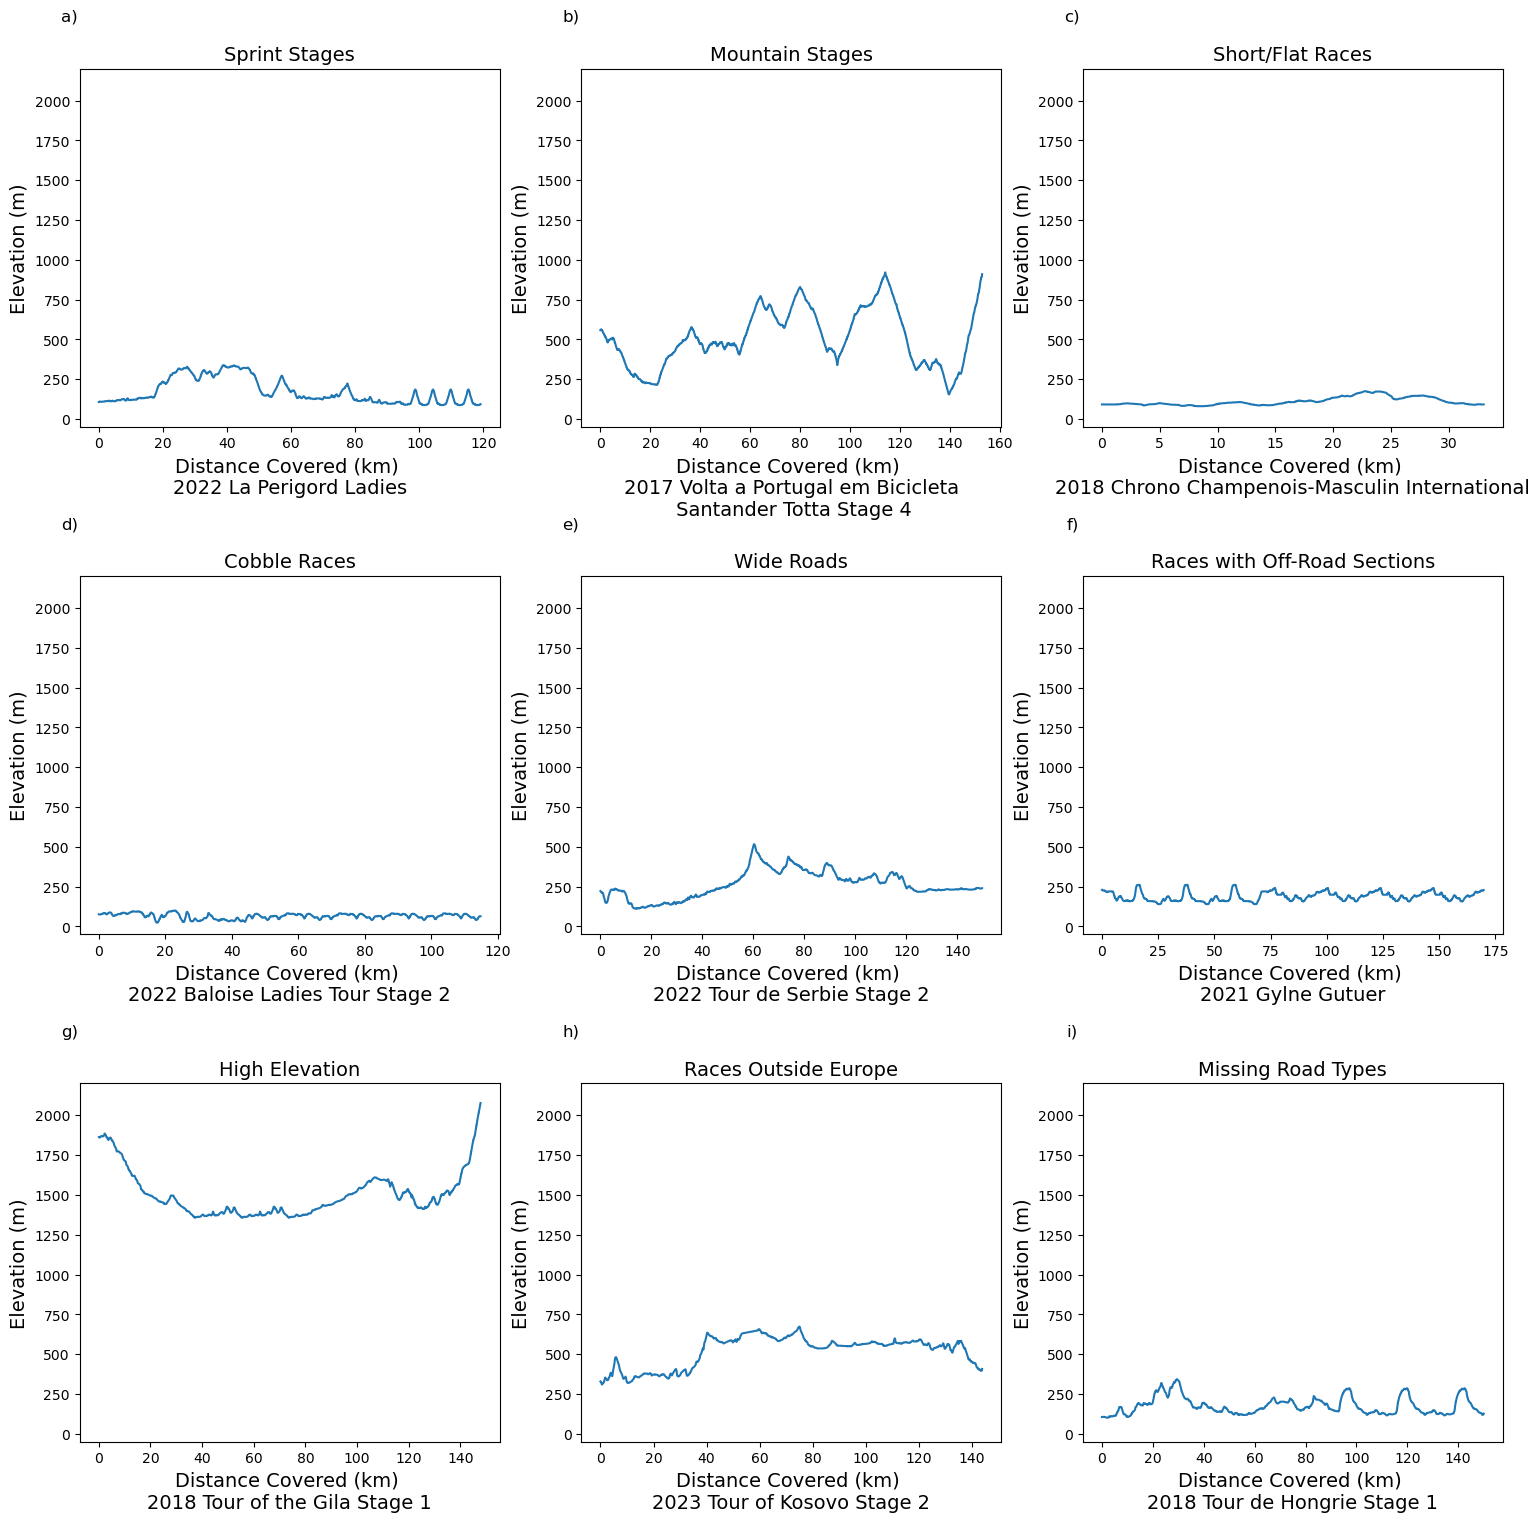

In [359]:
medoids()

In [363]:
races_2017_2023 = pd.read_csv('race_results_2017_2023.csv')
merged = races_2017_2023.merge(merged_set_constrained[['Race Name', 'Cluster']], on = 'Race Name')

In [367]:
points_aggregates = merged.groupby(['Cluster', 'Name'])['PCS points'].sum()

In [375]:
points_aggregates['Short/Flat Races'].sort_values(ascending = False).head(5)

Name
GANNA Filippo      1752.0
KÜNG Stefan        1663.0
DENNIS Rohan       1177.0
ROGLIČ Primož      1167.0
EVENEPOEL Remco    1130.0
Name: PCS points, dtype: float64

In [376]:
points_aggregates['Mountain Stages'].sort_values(ascending = False).head(5)

Name
POGAČAR Tadej         4646.0
ROGLIČ Primož         4189.0
VALVERDE Alejandro    2969.0
ALAPHILIPPE Julian    2383.0
PINOT Thibaut         2143.0
Name: PCS points, dtype: float64

In [377]:
points_aggregates['Missing Road Types'].sort_values(ascending = False).head(5)

Name
KRISTOFF Alexander    3784.0
SAGAN Peter           3681.0
VAN AVERMAET Greg     3671.0
VAN AERT Wout         3135.0
VIVIANI Elia          3021.0
Name: PCS points, dtype: float64

# Race Affinity

In [265]:
races_2017_2023 = pd.read_csv('race_results_2017_2023.csv')
structured_course_data = pd.read_csv('structured_course_data.csv')

structured_course_data = structured_course_data.fillna(0)

In [380]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import dateutil.parser

random.seed(1853)

races_talent = races_2017_2023[races_2017_2023['Name']=='AYUSO Juan'].merge(structured_course_data, on = 'Race Name')
races_talent['Date'] = races_talent['Date'].apply(dateutil.parser.parse)

races_talent['Year'] = races_talent['Date'].dt.to_period('Y')

races_talent['Rank'] = np.where(races_talent['Rank'].isin(['OTL', 'DNF', 'DSQ', 'DNS']), 1000, races_talent['Rank'])
races_talent['Podium'] = np.where(races_talent['Rank'].astype(float)<10.5,1,0)
races_talent = races_talent.drop(columns = ['Date', 'Rank', 'Team', 'Name', 'Time', 'UCI points',
       'PCS points', 'Team Time Trial', 'TimeAfterTeamTTT'])

train = races_talent[races_talent['Year'].astype(str).astype(int)!=2023]
test = races_talent[races_talent['Year'].astype(str).astype(int)==2023]

y_train = train['Podium']
x_train = train.drop(columns = ['Race Name', 'Year', 'Podium'])

y_test = test['Podium']
x_test = test.drop(columns = ['Race Name', 'Year', 'Podium'])

rf = RandomForestClassifier(random_state=0)
rf.fit(x_train, y_train)

y_pred = rf.predict_proba(x_test)

roc_auc_score(y_test, y_pred[:,1])

0.6467391304347826

In [381]:
ayuso = pd.DataFrame(np.matrix([test['Race Name'], y_pred[:,1]]).transpose())
ayuso.columns = ['Race Name', 'Probability']

ayuso.sort_values('Probability', ascending = False)

,Race Name,Probability
24,2023 Prueba Villafranca - Ordiziako Klasika,0.83
17,2023 La Vuelta Ciclista a Espana Stage 3,0.81
30,2023 Tour de Romandie Stage 4,0.75
20,2023 La Vuelta Ciclista a Espana Stage 6,0.74
7,2023 La Vuelta Ciclista a Espana Stage 13,0.71
16,2023 La Vuelta Ciclista a Espana Stage 21,0.69
37,2023 Tour de Suisse Stage 7,0.68
5,2023 La Vuelta Ciclista a Espana Stage 11,0.68
11,2023 La Vuelta Ciclista a Espana Stage 17,0.67
8,2023 La Vuelta Ciclista a Espana Stage 14,0.65


In [273]:
random.seed(1853)

races_talent = races_2017_2023[races_2017_2023['Name']=='CAVENDISH Mark'].merge(structured_course_data, on = 'Race Name')
races_talent['Date'] = races_talent['Date'].apply(dateutil.parser.parse)

races_talent['Year'] = races_talent['Date'].dt.to_period('Y')

races_talent['Rank'] = np.where(races_talent['Rank'].isin(['OTL', 'DNF', 'DSQ', 'DNS']), 1000, races_talent['Rank'])
races_talent['Podium'] = np.where(races_talent['Rank'].astype(float)<3.5,1,0)
races_talent = races_talent.drop(columns = ['Date', 'Rank', 'Team', 'Name', 'Time', 'UCI points',
       'PCS points', 'Team Time Trial', 'TimeAfterTeamTTT'])

train = races_talent[races_talent['Year'].astype(str).astype(int)!=2023]
test = races_talent[races_talent['Year'].astype(str).astype(int)==2023]

y_train = train['Podium']
x_train = train.drop(columns = ['Race Name', 'Year', 'Podium'])

y_test = test['Podium']
x_test = test.drop(columns = ['Race Name', 'Year', 'Podium'])

rf = RandomForestClassifier(random_state=0)
rf.fit(x_train, y_train)

y_pred = rf.predict_proba(x_test)

roc_auc_score(y_test, y_pred[:,1])

0.6192307692307693

In [274]:
cav = pd.DataFrame(np.matrix([test['Race Name'], y_pred[:,1]]).transpose())
cav.columns = ['Race Name', 'Probability']

cav.sort_values('Probability', ascending = False)

,Race Name,Probability
15,2023 Giro dItalia Stage 17,0.35
57,2023 Tour of Oman Stage 1,0.33
67,2023 ZLM Tour Stage 3,0.3
31,2023 Presidential Cycling Tour of Turkiye Stage 1,0.3
19,2023 Giro dItalia Stage 20,0.26
...,...,...
61,2023 Tour of Oman Stage 5,0.01
10,2023 Giro dItalia Stage 12,0.01
51,2023 Tour de France Stage 5,0.01
1,2023 E3 Saxo Classic,0.01


In [316]:
def race_affinity(save_as='race_affinity.jpg'):

    # Create a figure and axis
    fig, ax = plt.subplots(2, 2, figsize=(TWO_COL_SIZE_X, TWO_COL_SIZE_X * 0.5))
    
    files = [ayuso,cav]
    for j, file in enumerate(files):

        best = file.sort_values('Probability', ascending = False)['Race Name'].head(1).values[0]
        worst = file.sort_values('Probability', ascending = False)['Race Name'].tail(1).values[0]
        
        with open(initial+best+'.gpx', 'r', encoding="utf-8") as gpx_file2:
            route_info = []
            gpx = gpxpy.parse(gpx_file2)
            data_old = [data_point for data_point in gpx.tracks[0].segments[0].points]
        
        with open(initial+worst+'.gpx', 'r', encoding="utf-8") as gpx_file2:
            route_info = []
            gpx = gpxpy.parse(gpx_file2)
            data_new = [data_point for data_point in gpx.tracks[0].segments[0].points]
        # Preprocess old
        track_elevation_series = []

        route_info = []

        for data_point in data_old:
            track_elevation_series.append(data_point.elevation)
            route_info.append({
                'latitude': data_point.latitude,
                'longitude': data_point.longitude
            })

        route_df = pd.DataFrame(route_info)
        distances = [np.nan]
        for i in range(len(route_df)):
            if i == 0:
                continue
            else:
                distances.append(haversine_distance(
                    lat1=route_df.iloc[i - 1]['latitude'],
                    lon1=route_df.iloc[i - 1]['longitude'],
                    lat2=route_df.iloc[i]['latitude'],
                    lon2=route_df.iloc[i]['longitude']
                ))

        route_df['distance'] = distances

        route_df['Covered Distance'] = route_df['distance'].cumsum()
        route_df['Elevation'] = track_elevation_series

        old_df = route_df

        old_df = old_df.fillna(0)


        #ax[i][0].ylim((-50, 750))
        if j==1:
            ax[j][0].set_xlabel('Distance Covered (km)',  fontsize='14', horizontalalignment='center')
        ax[j][0].set_ylim((-50, 1500))
        ax[j][0].set_ylabel('Elevation (m)',  fontsize='14')
        ax[j][0].plot(np.array(old_df['Covered Distance']/1000), np.array(old_df['Elevation']))

        char = chr(97 + 2*j)
        
        ax[j, 0].text(-0.025, 1.1, '%s)' % char, fontsize=12,
                            horizontalalignment='center', verticalalignment='center',
                            transform=ax[j, 0].transAxes)
        track_elevation_series = []

        route_info = []

        for data_point in data_new:
            track_elevation_series.append(data_point.elevation)
            route_info.append({
                'latitude': data_point.latitude,
                'longitude': data_point.longitude
            })

        route_df = pd.DataFrame(route_info)
        distances = [np.nan]
        for i in range(len(route_df)):
            if i == 0:
                continue
            else:
                distances.append(haversine_distance(
                    lat1=route_df.iloc[i - 1]['latitude'],
                    lon1=route_df.iloc[i - 1]['longitude'],
                    lat2=route_df.iloc[i]['latitude'],
                    lon2=route_df.iloc[i]['longitude']
                ))

        route_df['distance'] = distances

        route_df['Covered Distance'] = route_df['distance'].cumsum()
        route_df['Elevation'] = track_elevation_series

        new_df = route_df
        new_df = new_df.fillna(0)    
        
        ax[j][1].plot(np.array(new_df['Covered Distance']/1000), np.array(new_df['Elevation']))

        
        if j==1:
            ax[j][1].set_xlabel('Distance Covered (km)', fontsize='14', horizontalalignment='center')
        ax[j][1].set_ylim((-50, 1500))

        char = chr(97 + 2*j + 1)
        
        ax[j, 1].text(-0.025, 1.1, '%s)' % char, fontsize=12,
                            horizontalalignment='center', verticalalignment='center',
                            transform=ax[j, 1].transAxes)
    
    #fig.tight_layout(pad=0)

    plt.savefig(f'Images/{save_as}', bbox_inches='tight')
    plt.show()


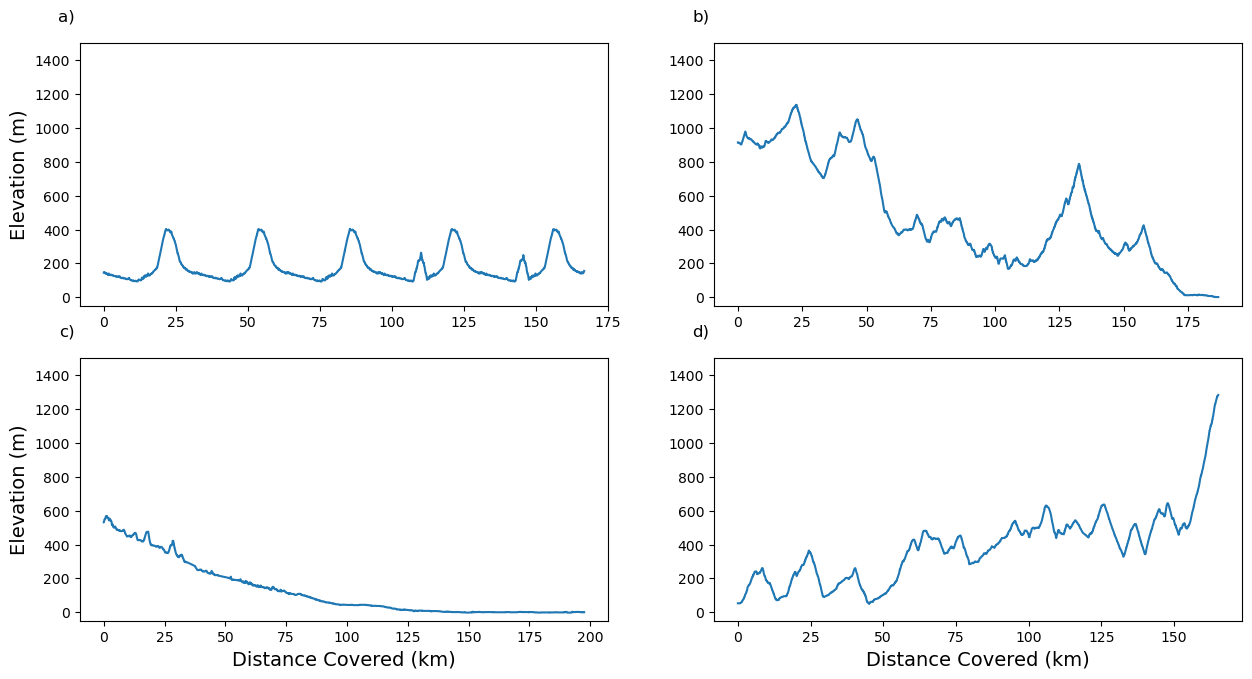

In [317]:
race_affinity()